In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Working on new docking oracles.

In [3]:
from dgym.envs.oracle import DockingOracle, NeuralOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 44.294,
    'center_y': 28.123,
    'center_z': 2.617,
    'size_x': 15.0,
    'size_y': 15.0,
    'size_z': 15.0,
    'search_mode': 'balanced',
    'scoring': 'gnina',
    'seed': 5
}

# Create noiseless evaluators
docking_oracle = DockingOracle(
    'ADAM17 affinity',
    receptor_path=f'../../dgym-data/ADAM17.pdbqt',
    config=config
)

docking_utility = ClassicUtilityFunction(
    docking_oracle,
    ideal=(9.5, 11.5),
    acceptable=(7.125, 9.5)
)

# Create noisy evaluator
noisy_docking_oracle = NoisyOracle(
    docking_oracle,
    sigma=0.7
)

noisy_docking_utility = ClassicUtilityFunction(
    noisy_docking_oracle,
    ideal=(8.5, 9.5),
    acceptable=(7.125, 9.5)
)

Run experiment.

In [4]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = deck[10:15].update_annotations(),
    assays = [docking_utility.oracle.reset_cache()],
    budget = 400,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 2, 'strict': False}},
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 2, 'strict': True}},
    {'name': 'ADAM17 affinity'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = docking_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 5
)

experiment = Experiment(drug_agent, drug_env)

print(experiment.drug_env.assays['ADAM17 affinity'](experiment.drug_env.library)[0])
result = experiment.run(1, progress=True)

5.605840449494839


  0%|                                       | 0/400 [00:00<?, ?it/s]

5.605840449494839



  6%|█▉                            | 26/400 [00:08<02:21,  2.64it/s]

8.032284388544749



  9%|██▋                           | 36/400 [00:15<03:08,  1.93it/s]

8.032284388544749



 10%|███▏                          | 42/400 [00:55<12:22,  2.07s/it]

8.032284388544749



 13%|███▉                          | 52/400 [01:05<09:45,  1.68s/it]

8.248483880788376
8.248483880788376



 14%|████▏                         | 56/400 [02:19<26:46,  4.67s/it]

8.248483880788376


  0%|                                         | 0/1 [02:28<?, ?it/s]


KeyboardInterrupt: 

Visualizing affinity in chemical networks.

In [11]:
import networkx as nx

affinity = []
G = nx.DiGraph()
G.add_node('start')
for mol in drug_env.library:
    if mol.smiles not in G:
        G.add_node(mol.name)
        # affinity.extend(docking_oracle([mol]))

        if mol.inspiration is not None:
            if mol.inspiration.name != mol.name:
                G.add_edge(mol.inspiration.name, mol.name)
        else:
            G.add_edge('start', mol.name)

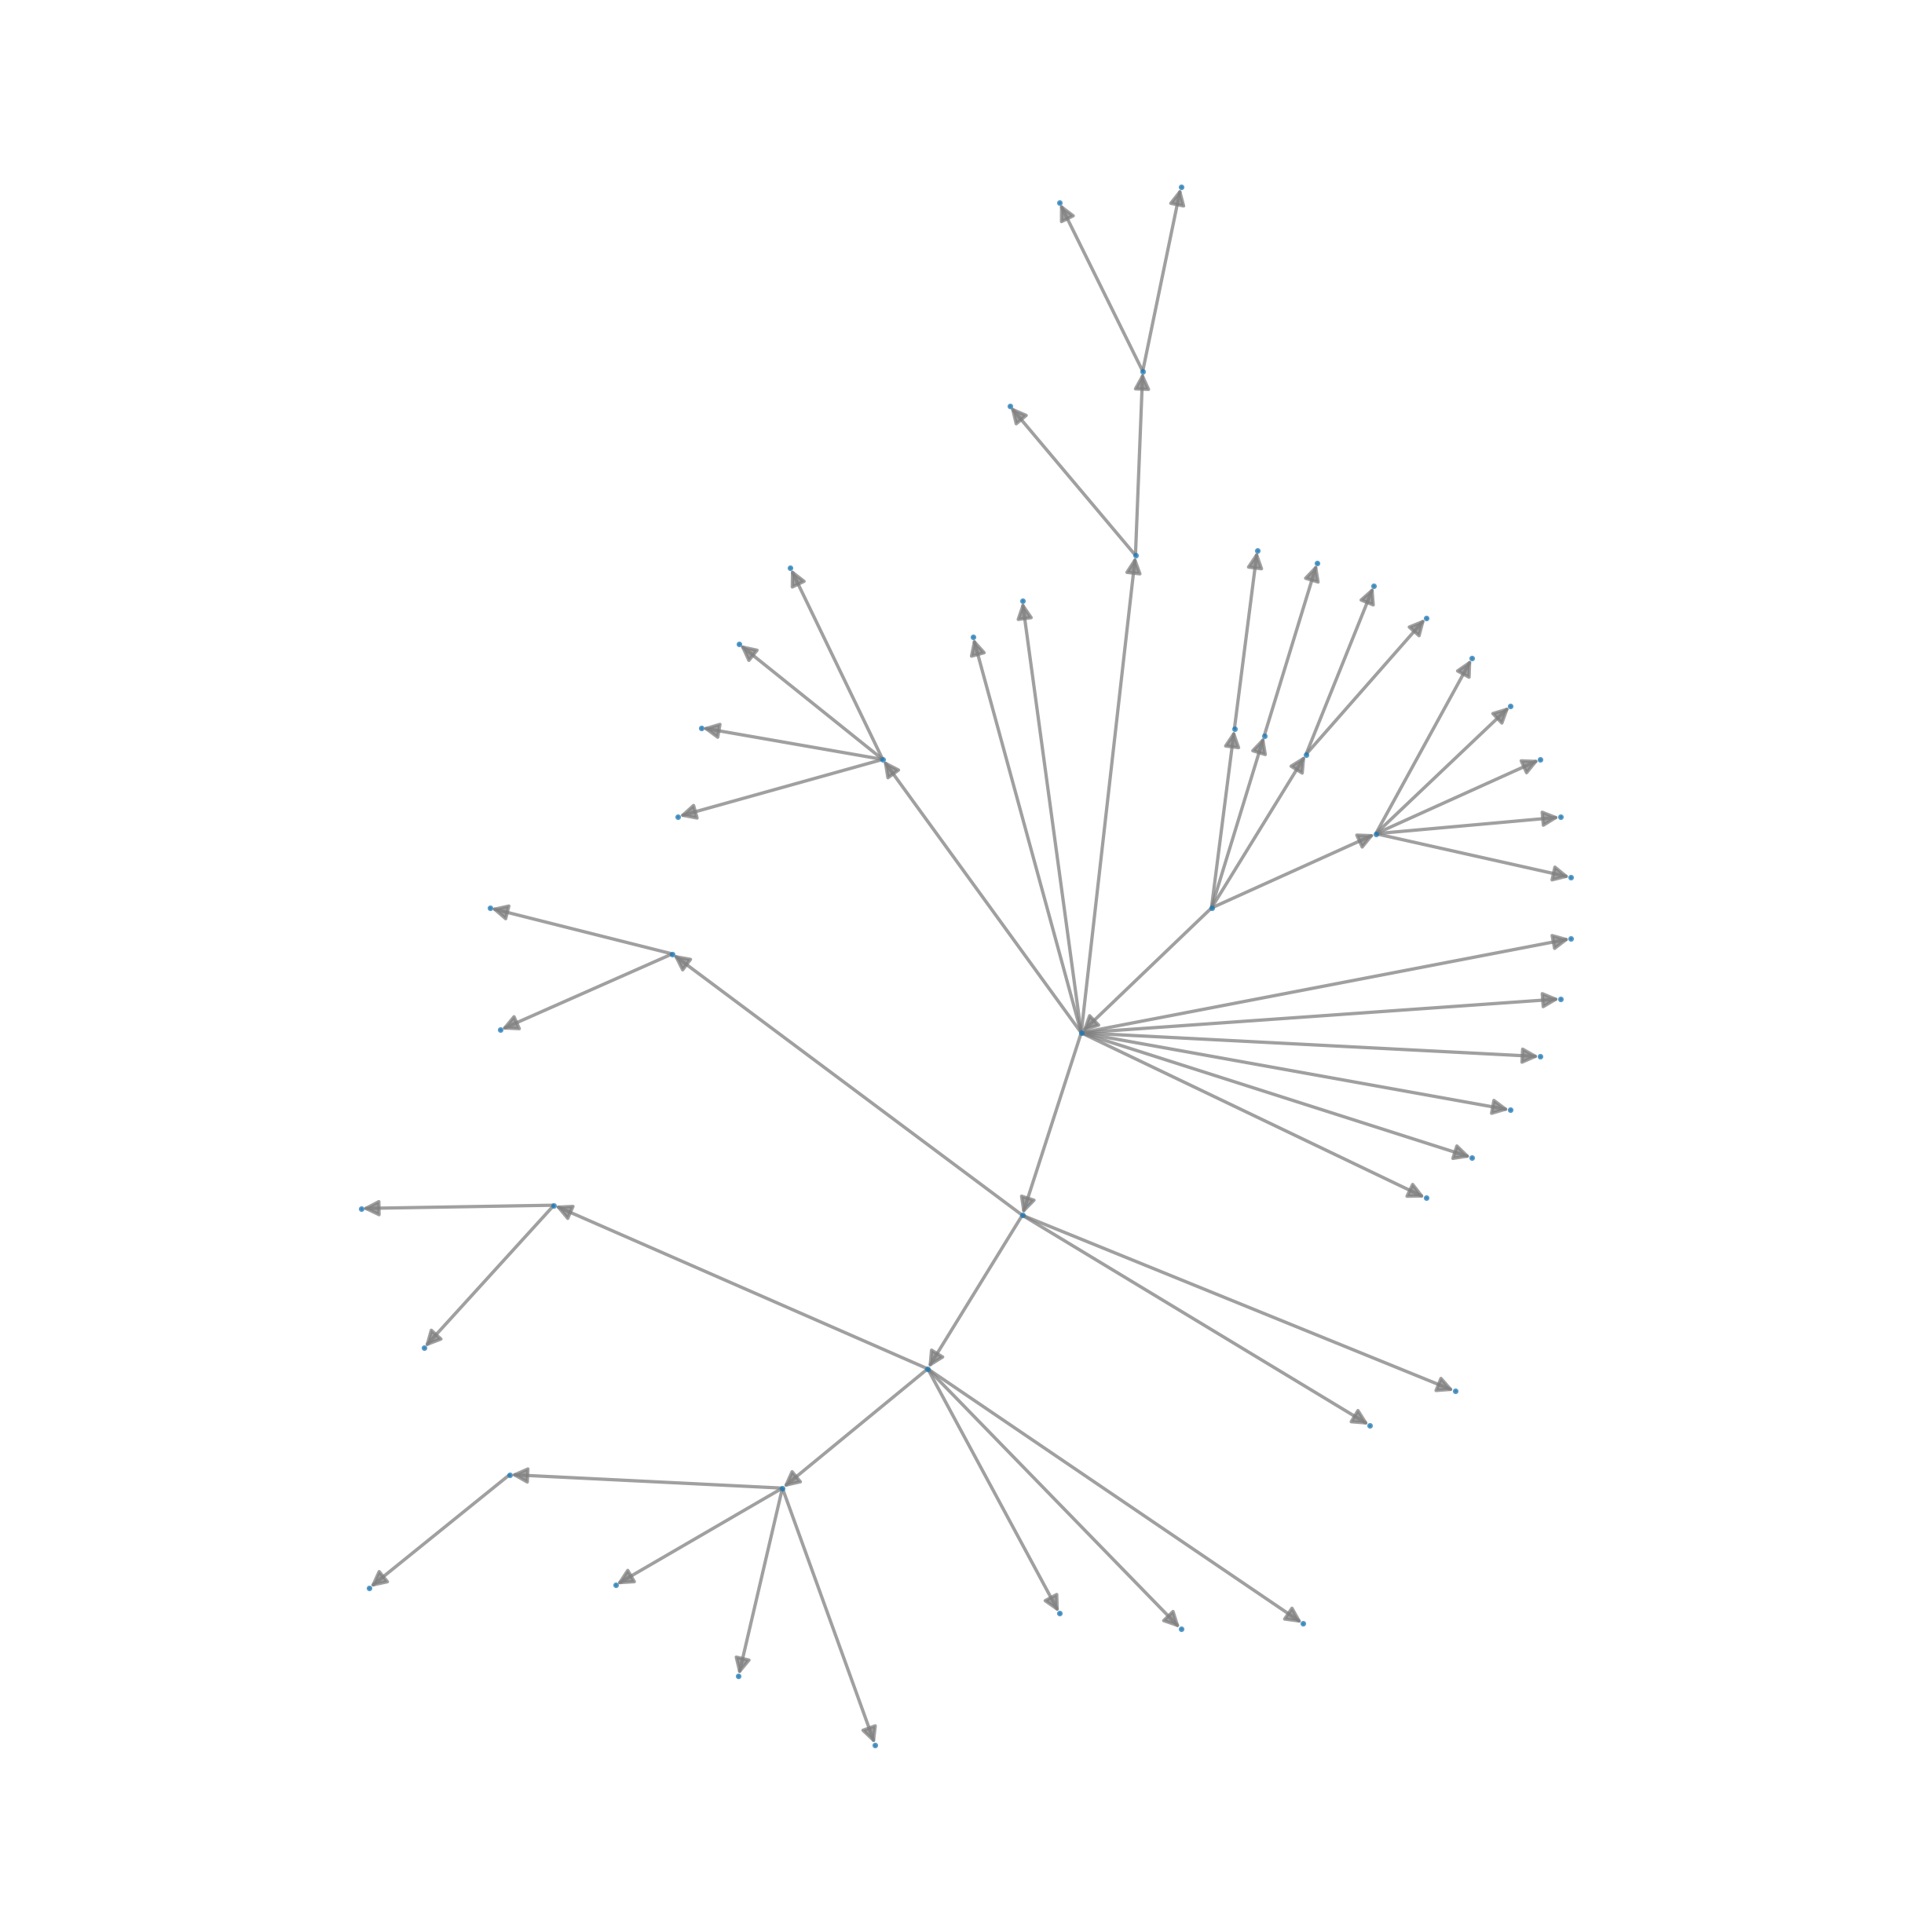

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")

plt.figure(figsize=(8, 8), dpi=300)
nx.draw(
    G,
    pos,
    node_size=0.5,
    alpha=0.75,
    # node_color=[0, *affinity],
    edge_color = 'grey',
    with_labels=False
)
plt.axis("equal")
plt.show()

In [14]:
import numpy as np
import networkx

drug_env.library.update_annotations([
    {'index': i + 2}
    for i in range(len(drug_env.library))
])

affinity = []
adjacency_list = [{'id': 1, 'name': 'universal'}]
for idx, mol in enumerate(drug_env.library):
    
    annotations = {
        'id': mol['index'],
        'name': mol.name,
        'size': np.random.randint(0, 2000)
    }

    if mol.inspiration is not None:
        inspiration = mol.inspiration
        if inspiration.name != mol.name:
            annotations.update({'parent': inspiration['index']})
    else:
        annotations.update({'parent': 1})
            
    adjacency_list.append(annotations)

import json
json.dump(
    adjacency_list,
    open('../../dgym-data/trajectory.json', 'w'),
    indent=2
)

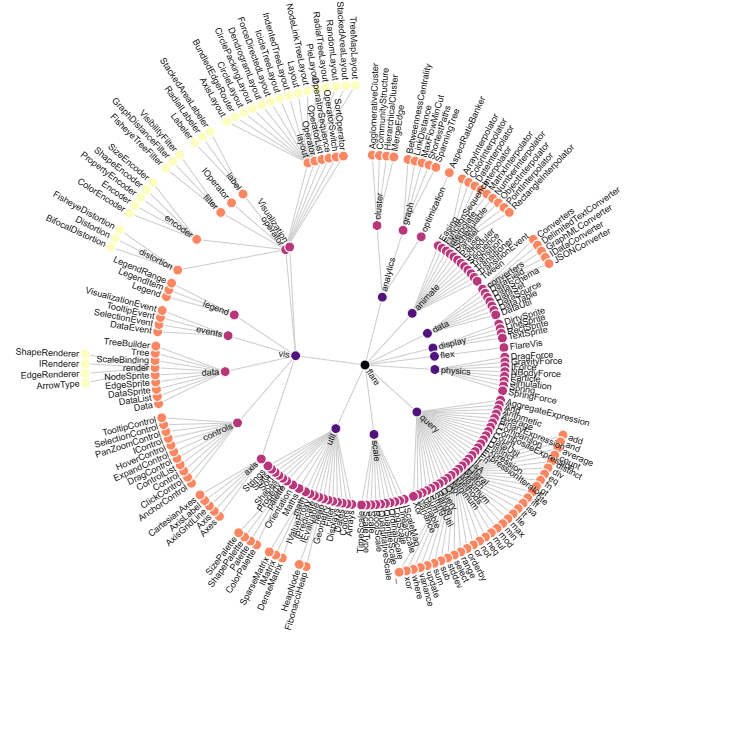

In [15]:
import json
from IPython.display import display

vg_spec = r"""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of a radial layout for a node-link diagram of hierarchical data.",
  "width": 720,
  "height": 720,
  "padding": 5,
  "autosize": "none",

  "signals": [
    {
      "name": "labels", "value": true,
      "bind": {"input": "checkbox"}
    },
    {
      "name": "radius", "value": 280,
      "bind": {"input": "range", "min": 20, "max": 600}
    },
    {
      "name": "extent", "value": 360,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "rotate", "value": 0,
      "bind": {"input": "range", "min": 0, "max": 360, "step": 1}
    },
    {
      "name": "layout", "value": "tidy",
      "bind": {"input": "radio", "options": ["tidy", "cluster"]}
    },
    {
      "name": "links", "value": "line",
      "bind": {
        "input": "select",
        "options": ["line", "curve", "diagonal", "orthogonal"]
      }
    },
    { "name": "originX", "update": "width / 2" },
    { "name": "originY", "update": "height / 2" }
  ],

  "data": [
    {
      "name": "tree",
      "url": "../../dgym-data/flare.json",
      "transform": [
        {
          "type": "stratify",
          "key": "id",
          "parentKey": "parent"
        },
        {
          "type": "tree",
          "method": {"signal": "layout"},
          "size": [1, {"signal": "radius"}],
          "as": ["alpha", "radius", "depth", "children"]
        },
        {
          "type": "formula",
          "expr": "(rotate + extent * datum.alpha + 270) % 360",
          "as":   "angle"
        },
        {
          "type": "formula",
          "expr": "PI * datum.angle / 180",
          "as":   "radians"
        },
        {
          "type": "formula",
          "expr": "inrange(datum.angle, [90, 270])",
          "as":   "leftside"
        },
        {
          "type": "formula",
          "expr": "originX + datum.radius * cos(datum.radians)",
          "as":   "x"
        },
        {
          "type": "formula",
          "expr": "originY + datum.radius * sin(datum.radians)",
          "as":   "y"
        }
      ]
    },
    {
      "name": "links",
      "source": "tree",
      "transform": [
        { "type": "treelinks" },
        {
          "type": "linkpath",
          "shape": {"signal": "links"}, "orient": "radial",
          "sourceX": "source.radians", "sourceY": "source.radius",
          "targetX": "target.radians", "targetY": "target.radius"
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "linear",
      "range": {"scheme": "magma"},
      "domain": {"data": "tree", "field": "depth"},
      "zero": true
    }
  ],

  "marks": [
    {
      "type": "path",
      "from": {"data": "links"},
      "encode": {
        "update": {
          "x": {"signal": "originX"},
          "y": {"signal": "originY"},
          "path": {"field": "path"},
          "stroke": {"value": "#ccc"}
        }
      }
    },
    {
      "type": "symbol",
      "from": {"data": "tree"},
      "encode": {
        "enter": {
          "size": {"value": 100},
          "stroke": {"value": "#fff"}
        },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "fill": {"scale": "color", "field": "depth"}
        }
      }
    },
    {
      "type": "text",
      "from": {"data": "tree"},
      "encode": {
        "enter": {
          "text": {"field": "name"},
          "fontSize": {"value": 9},
          "baseline": {"value": "middle"}
        },
        "update": {
          "x": {"field": "x"},
          "y": {"field": "y"},
          "dx": {"signal": "(datum.leftside ? -1 : 1) * 6"},
          "angle": {"signal": "datum.leftside ? datum.angle - 180 : datum.angle"},
          "align": {"signal": "datum.leftside ? 'right' : 'left'"},
          "opacity": {"signal": "labels ? 1 : 0"}
        }
      }
    }
  ]
}
"""

display(
    {"application/vnd.vega.v5+json": json.loads(vg_spec)},
    raw=True
)

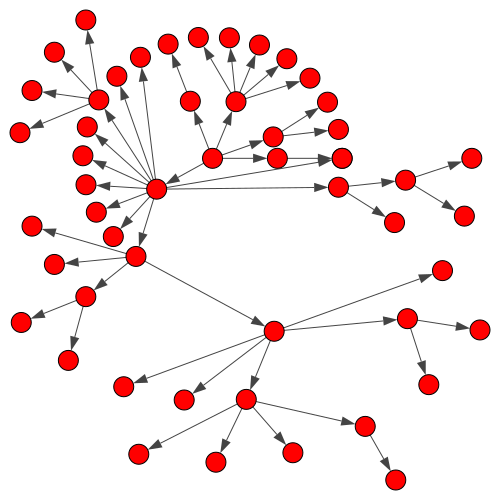

In [197]:
import math
import numpy as np
import igraph as ig

adjacency_tuples = [
    (a['id'], a['parent']) for a in adjacency_list if 'parent' in a
]

adjacency_tuples = []
for molecule in drug_env.library:
    if molecule.inspiration \
        and molecule.inspiration != molecule:
        adjacency_tuple = (molecule.inspiration.name, molecule.name)
        adjacency_tuples.append(adjacency_tuple)
    else:
        adjacency_tuple = ('parent', molecule.name)
        adjacency_tuples.append(adjacency_tuple)

g = ig.Graph.TupleList(set(adjacency_tuples), directed=True)


def polar_to_cartesian(coordinates):
    """
    Convert coordinates from a custom Reingold-Tilford format to radial layout.
    
    Parameters
    ----------
    coordinates : list of lists
        The coordinates from a Reingold-Tilford algorithm output, where the first
        element of each inner list is treated as an angle (after scaling) and the
        second element as the radius.
    
    Returns
    -------
    np.ndarray
        Array of Cartesian coordinates in radial layout.
    """
    # Convert list to numpy array for convenience
    coordinates = np.array(coordinates)
    
    # Normalize x values to the range [0, 2*pi] to represent angles
    x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
    angles = 2 * np.pi * (coordinates[:, 0] - x_min) / (x_max - x_min)
    
    # Use y values as radii
    radii = coordinates[:, 1]
    
    # Convert polar to Cartesian coordinates
    x_cartesian = radii * np.cos(angles)
    y_cartesian = radii * np.sin(angles)
    
    return ig.layout.Layout(np.column_stack((x_cartesian, y_cartesian)))

layout = g.layout("rt")
ig.plot(
    g,
    layout=polar_to_cartesian(layout),
    bbox=(500, 500),
    # target='mygraph.png'
)

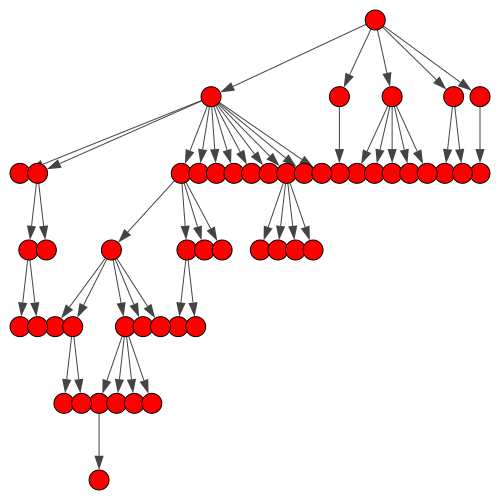

In [198]:
ig.plot(
    g,
    layout=layout,
    bbox=(500, 500),
    # target='mygraph.png'
)